# Implementing Different Methods

## Preamble

In [1]:
# libraries
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS
from scipy.special import expit # logi link|
import cvxpy as cp

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

### Helpers

In [2]:
def load_data(path):
    df = pd.read_stata(path).copy()
    return df

def fmt_result(name, coef, se, n, extra=None):
    out = {"method": name, "coef": coef, "SE": se, "N": n}
    if extra:
        out.update(extra)
    return out

def tri_weights(x, h):
    # triangular kernel weights for |x| <= h
    w = 1 - (np.abs(x) / h)
    return np.clip(w, 0, None)

In [3]:
# load the data
DATA_PATH = "../data/class_size.dta"

df = load_data(DATA_PATH)

# exclude pilot schools
pilot_schools = [22,23,24,25]
df["pilot"] = df["school_id"].isin(pilot_schools).astype(int)
df_nopilot = df[df["pilot"] == 0].copy()

results = []

## OLS

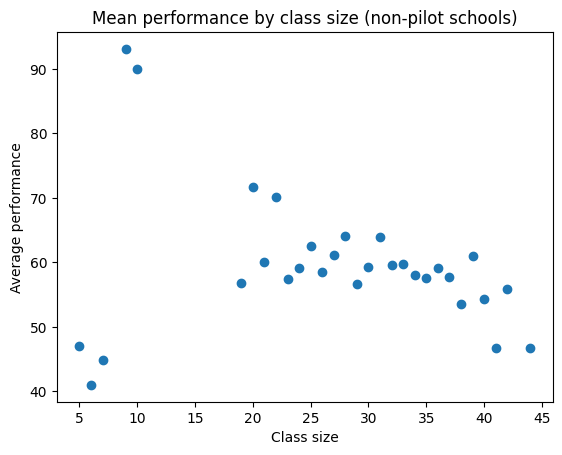

In [5]:
mean_by_cs = (
    df_nopilot.groupby("class_size", as_index=False)["perf"]
             .mean()
             .sort_values("class_size")
)

plt.figure()
plt.scatter(mean_by_cs["class_size"], mean_by_cs["perf"])
plt.xlabel("Class size")
plt.ylabel("Average performance")
plt.title("Mean performance by class size (non-pilot schools)")
plt.show()

In [6]:
# OLS 1: perf ~ class_size
ols1 = smf.ols("perf ~ class_size", data=df_nopilot).fit(cov_type="HC1")

# OLS 2: add controls
ols2 = smf.ols("perf ~ class_size + gender + income", data=df_nopilot).fit(cov_type="HC1")

In [7]:
print(ols1.summary().tables[1])
print(ols2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.4641      0.833     98.973      0.000      80.831      84.097
class_size    -0.7186      0.027    -26.729      0.000      -0.771      -0.666
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.6154      0.366     97.415      0.000      34.899      36.332
class_size    -0.3751      0.011    -33.037      0.000      -0.397      -0.353
gender         0.0605      0.123      0.493      0.622      -0.180       0.301
income         0.7002      0.003    227.452      0.000       0.694       0.706


In [8]:
results.append(fmt_result("OLS (HC1): perf~class_size", ols1.params["class_size"], ols1.bse["class_size"], int(ols1.nobs)))

### Comments

placeholder

## Matching

In [9]:
THRESH = 30
df_m = df_nopilot.dropna(subset=["perf","class_size","gender","income"]).copy()
df_m["treated_small"] = (df_m["class_size"] <= THRESH).astype(int)

# coarsen income
df_m["income_bin"] = pd.qcut(df_m["income"], q=5, duplicates="drop")

# define strata for exact matching
df_m["stratum"] = df_m["gender"].astype(str) + "|" + df_m["income_bin"].astype(str)

# keep strata w at least one treated and one control
counts = df_m.groupby(["stratum","treated_small"]).size().unstack(fill_value=0)
valid_strata = counts[(counts[0] > 0) & (counts[1] > 0)].index
df_mm = df_m[df_m["stratum"].isin(valid_strata)].copy()

# computed matched difference in means
g = df_mm.groupby(["stratum","treated_small"])["perf"].mean().unstack()
stratum_sizes = df_mm.groupby("stratum").size()
ate_cem = np.average(g[1] - g[0], weights=stratum_sizes.loc[g.index])

# quick SE via bootstrap
B = 200
rng = np.random.default_rng(123)
boot = []
for b in range(B):
    samp = df_mm.sample(frac=1.0, replace=True, random_state=int(rng.integers(1e9)))
    gg = samp.groupby(["stratum","treated_small"])["perf"].mean().unstack()
    # only strata that still have both groups
    gg = gg.dropna()
    ss = samp.groupby("stratum").size().reindex(gg.index)
    boot.append(np.average(gg[1] - gg[0], weights=ss))
se_cem = np.std(boot, ddof=1)

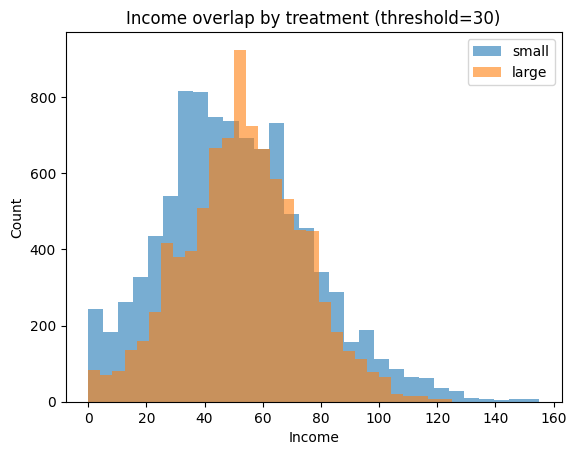

In [10]:
# Plot overlap in income by treatment
plt.figure()
plt.hist(df_m.loc[df_m["treated_small"]==1, "income"], bins=30, alpha=0.6, label="small")
plt.hist(df_m.loc[df_m["treated_small"]==0, "income"], bins=30, alpha=0.6, label="large")
plt.title(f"Income overlap by treatment (threshold={THRESH})")
plt.xlabel("Income")
plt.ylabel("Count")
plt.legend()
plt.show()

In [11]:
print(f"CEM-style matched ATE (small<= {THRESH} vs large): {ate_cem:.4f}  (boot SE ~ {se_cem:.4f}), N={len(df_mm)}")
results.append(fmt_result(f"Matching (CEM bins, thresh={THRESH})", ate_cem, se_cem, int(len(df_mm)),
                          extra={"treatment": f"1[class_size<={THRESH}]"}))

CEM-style matched ATE (small<= 30 vs large): 4.9846  (boot SE ~ 0.1377), N=18585


### Comments

This is a binary treatment estimand; it's not directly comparable to the slope estimates from OLS/FE/IV.

## Individual Fixed Effects

In [12]:
df_fe = df_nopilot.dropna(subset=["student_id","year","perf","class_size","school_id"]).copy()
df_fe = df_fe.set_index(["student_id","year"]).sort_index()

Y = df_fe["perf"]
X = df_fe[["class_size","gender","income"]].copy() # may include absorbed vars

clusters_school = df_fe["school_id"]

fe_student = PanelOLS(
    Y, X,
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True # drop vars that don't change within student
).fit(cov_type="clustered", clusters=clusters_school)

print(fe_student.summary)
print("Kept regressors:", list(fe_student.params.index))

                          PanelOLS Estimation Summary                           
Dep. Variable:                   perf   R-squared:                        0.2839
Estimator:                   PanelOLS   R-squared (Between):              0.4777
No. Observations:               18585   R-squared (Within):               0.2342
Date:                Tue, Feb 17 2026   R-squared (Overall):              0.4758
Time:                        19:24:35   Log-likelihood                -5.479e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3063.0
Entities:                        3127   P-value                           0.0000
Avg Obs:                       5.9434   Distribution:                 F(2,15451)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             2223.7
                            

/tmp/ipykernel_550580/2828635070.py:14: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gender

  ).fit(cov_type="clustered", clusters=clusters_school)


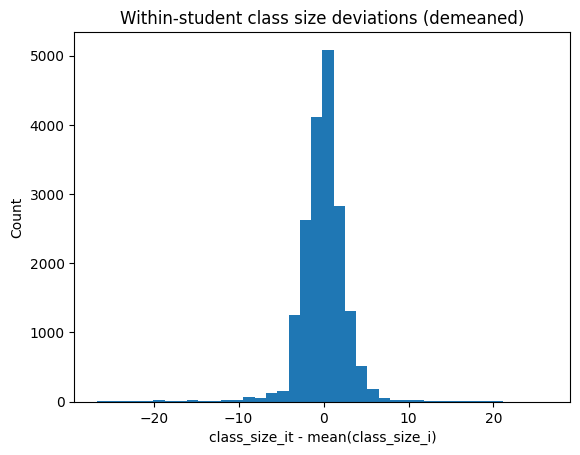

In [13]:
within_cs = df_fe["class_size"] - df_fe.groupby(level=0)["class_size"].transform("mean")

plt.figure()
plt.hist(within_cs.dropna(), bins=40)
plt.title("Within-student class size deviations (demeaned)")
plt.xlabel("class_size_it - mean(class_size_i)")
plt.ylabel("Count")
plt.show()

In [14]:
b = float(fe_student.params["class_size"])
se = float(fe_student.std_errors["class_size"])
n = int(fe_student.nobs)
results.append(fmt_result("Student FE + Year FE (cluster school)", b, se, n, extra={"cluster":"school"}))

### Comments

placeholder

## Twin Fixed Effects

In [15]:
df_tw = df_nopilot.dropna(subset=["twin_id","year","perf","class_size"]).copy()

# keep only twin IDs with variation in class size
var = df_tw.groupby("twin_id")["class_size"].transform(lambda s: s.max() - s.min())
df_tw = df_tw[var > 0].copy()

                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              41.3590      2.240     18.463      0.000      36.969      45.749
C(twin_id)[T.2.0]      -8.7303      1.445     -6.040      0.000     -11.563      -5.898
C(twin_id)[T.3.0]      -8.4412      1.461     -5.776      0.000     -11.305      -5.577
C(twin_id)[T.7.0]      10.7865      1.106      9.756      0.000       8.620      12.954
C(twin_id)[T.8.0]       4.9433      1.090      4.536      0.000       2.807       7.079
C(twin_id)[T.9.0]      10.8417      1.399      7.748      0.000       8.099      13.584
C(twin_id)[T.10.0]     11.6311      1.388      8.379      0.000       8.910      14.352
C(twin_id)[T.11.0]      1.5646      2.060      0.760      0.448      -2.473       5.602
C(twin_id)[T.12.0]     18.4337      1.008     18.287      0.000      16.458      20.409
C(twin_id)[T.13.0]     -2.7768  

/home/venatio/documents/university/impact-eval-2026/.venv/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 157, but rank is 8
  warnings.warn('covariance of constraints does not have full '


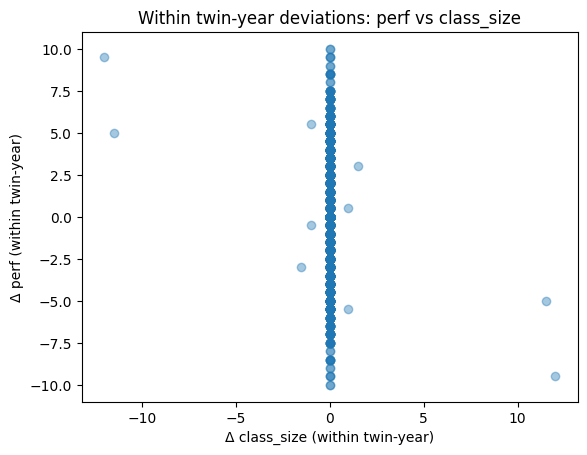

In [16]:
if len(df_tw) == 0:
    print("No twin pairs with within-pair class size variation after filtering.")
    results.append(fmt_result("Twin FE + Year FE", np.nan, np.nan, 0))
else:
    twin_fe = smf.ols("perf ~ class_size + gender + income + C(twin_id) + C(year)", data=df_tw).fit(
        cov_type="cluster", cov_kwds={"groups": df_tw["twin_id"]}
    )
    print(twin_fe.summary().tables[1])

    # twin-difference plot (within twin_id & year): delta perf vs delta class_size
    # (within year devs)
    df_tw["_perf_dev"] = df_tw["perf"] - df_tw.groupby(["twin_id","year"])["perf"].transform("mean")
    df_tw["_cs_dev"]   = df_tw["class_size"] - df_tw.groupby(["twin_id","year"])["class_size"].transform("mean")
    plt.figure()
    plt.scatter(df_tw["_cs_dev"], df_tw["_perf_dev"], alpha=0.4)
    plt.title("Within twin-year deviations: perf vs class_size")
    plt.xlabel("Δ class_size (within twin-year)")
    plt.ylabel("Δ perf (within twin-year)")
    plt.show()

    results.append(fmt_result("Twin FE + Year FE (cluster twin)", twin_fe.params["class_size"], twin_fe.bse["class_size"], int(twin_fe.nobs),
                              extra={"cluster":"twin"}))

### Comments

placeholder

## Difference in Differences

In [17]:
df_did = df.dropna(subset=["perf","school_id","year"]).copy()

# infer pilot start year from the "enrollments <= 15" rule in pilot schools
pilot_mean_enr = df_did[df_did["pilot"]==1].groupby("year")["enrollments"].mean()
cand = pilot_mean_enr[pilot_mean_enr <= 15].index.tolist()
post_start = int(min(cand)) if len(cand) else int(df_did["year"].min())

df_did["post"] = (df_did["year"] >= post_start).astype(int)
df_did["did"]  = df_did["pilot"] * df_did["post"]

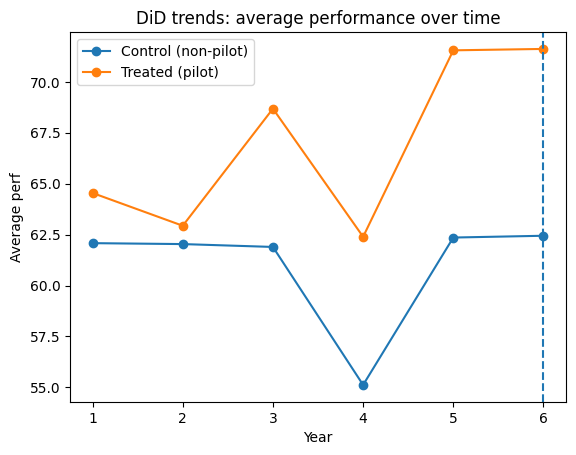

In [18]:
# plot trends: avg perf over time for treated vs control
trend = df_did.groupby(["year","pilot"], as_index=False)["perf"].mean()
plt.figure()
for g, lab in [(0,"Control (non-pilot)"), (1,"Treated (pilot)")]:
    tmp = trend[trend["pilot"]==g]
    plt.plot(tmp["year"], tmp["perf"], marker="o", label=lab)
plt.axvline(post_start, linestyle="--")
plt.title("DiD trends: average performance over time")
plt.xlabel("Year")
plt.ylabel("Average perf")
plt.legend()
plt.show()

In [19]:
#did_mod = smf.ols("perf ~ pilot + post + did + gender + income", data=df_did).fit(
#   cov_type="cluster", cov_kwds={"groups": df_did["school_id"]}
#)
did_mod = smf.ols(
    "perf ~ did + C(school_id) + C(year) + gender + income",
    data=df_did
).fit(cov_type="cluster", cov_kwds={"groups": df_did["school_id"]})

print(did_mod.summary().tables[1])

results.append(fmt_result(f"DiD (post>= {post_start})", did_mod.params["did"], did_mod.bse["did"], int(did_mod.nobs),
                          extra={"cluster":"school"}))

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               26.3923      0.920     28.676      0.000      24.588      28.196
C(school_id)[T.2.0]     -1.8917      0.028    -67.306      0.000      -1.947      -1.837
C(school_id)[T.3.0]      1.4152      0.452      3.134      0.002       0.530       2.300
C(school_id)[T.4.0]     -3.7064      0.399     -9.281      0.000      -4.489      -2.924
C(school_id)[T.5.0]     -1.0742      0.421     -2.549      0.011      -1.900      -0.248
C(school_id)[T.6.0]      7.6502      0.444     17.236      0.000       6.780       8.520
C(school_id)[T.7.0]     13.1945      0.401     32.903      0.000      12.408      13.980
C(school_id)[T.8.0]     -8.2184      0.419    -19.628      0.000      -9.039      -7.398
C(school_id)[T.9.0]     -1.6332      0.435     -3.758      0.000      -2.485      -0.781
C(school_id)[T.10.0] 

/home/venatio/documents/university/impact-eval-2026/.venv/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 8
  warnings.warn('covariance of constraints does not have full '


### Event Study Plot

In [20]:
df_es = df_did.copy()
df_es["event_time"] = df_es["year"] - post_start

# choose window
W = 3
df_es = df_es[(df_es["event_time"] >= -W) & (df_es["event_time"] <= W)].copy()

# create safe dummy names; omit -1 as reference
def et_name(k):
    if k < 0:
        return f"ET_m{abs(k)}"
    elif k > 0:
        return f"ET_p{k}"
    else:
        return "ET_0"

et_vars = []
for k in range(-W, W+1):
    if k == -1:
        continue
    v = et_name(k)
    df_es[v] = ((df_es["event_time"] == k).astype(int) * df_es["pilot"])
    et_vars.append(v)

terms = " + ".join(et_vars)

es_mod = smf.ols(
    f"perf ~ C(year) + C(school_id) + {terms} + gender + income",
    data=df_es
).fit(cov_type="cluster", cov_kwds={"groups": df_es["school_id"]})

print(es_mod.summary().tables[1])

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               26.6640      0.904     29.483      0.000      24.891      28.437
C(year)[T.4.0]          -6.8020      0.365    -18.642      0.000      -7.517      -6.087
C(year)[T.5.0]           0.2878      0.361      0.798      0.425      -0.419       0.994
C(year)[T.6.0]           0.5724      0.332      1.722      0.085      -0.079       1.224
C(school_id)[T.2.0]     -2.2634      0.029    -78.415      0.000      -2.320      -2.207
C(school_id)[T.3.0]      0.8880      0.445      1.995      0.046       0.016       1.760
C(school_id)[T.4.0]     -4.4897      0.389    -11.543      0.000      -5.252      -3.727
C(school_id)[T.5.0]     -1.1724      0.415     -2.827      0.005      -1.985      -0.359
C(school_id)[T.6.0]      6.5483      0.438     14.944      0.000       5.689       7.407
C(school_id)[T.7.0]  

/home/venatio/documents/university/impact-eval-2026/.venv/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 60, but rank is 8
  warnings.warn('covariance of constraints does not have full '


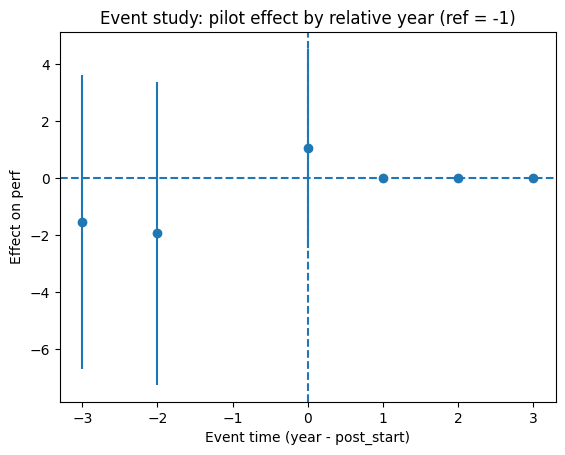

In [21]:
# extract coeffs in the right order for plotting
ks = [k for k in range(-W, W+1) if k != -1]
coefs, ses = [], []
for k in ks:
    v = et_name(k)
    coefs.append(es_mod.params.get(v, np.nan))
    ses.append(es_mod.bse.get(v, np.nan))

plt.figure()
plt.errorbar(ks, coefs, yerr=1.96*np.array(ses), fmt="o")
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Event study: pilot effect by relative year (ref = -1)")
plt.xlabel("Event time (year - post_start)")
plt.ylabel("Effect on perf")
plt.show()

### Placebo Test

In [40]:
def run_did(df_in, placebo_start_year):
    """
    Re-runs the exact same DiD specification you use,
    but defines post/did using a placebo start year.
    """
    d = df_in.copy()
    d["post_pl"] = (d["year"] >= placebo_start_year).astype(int)
    d["did_pl"] = d["pilot"] * d["post_pl"]

    mod = smf.ols(
        "perf ~ did_pl + C(school_id) + C(year) + gender + income",
        data=d
    ).fit(cov_type="cluster", cov_kwds={"groups": d["school_id"]})

    return mod

In [41]:
placebo_years = [post_start - 1, post_start - 2]

placebo_rows = []
for y0 in placebo_years:
    pl_mod = run_did(df_did, y0)
    placebo_rows.append({
        "placebo_start": y0,
        "coef_did": float(pl_mod.params["did_pl"]),
        "se": float(pl_mod.bse["did_pl"]),
        "pval": float(pl_mod.pvalues["did_pl"]),
        "N": int(pl_mod.nobs),
    })

In [42]:
placebo_df = pd.DataFrame(placebo_rows).sort_values("placebo_start")
print("\n=== Placebo DiD results (fake treatment year earlier) ===")
print(placebo_df)


=== Placebo DiD results (fake treatment year earlier) ===
   placebo_start  coef_did        se      pval      N
1              4  3.124743  1.896143  0.099364  19459
0              5  4.148059  2.278138  0.068636  19459


In [43]:
true_row = pd.DataFrame([{
    "placebo_start": post_start,
    "coef_did": float(did_mod.params["did"]),
    "se": float(did_mod.bse["did"]),
    "pval": float(did_mod.pvalues["did"]),
    "N": int(did_mod.nobs),
}])

compare_df = pd.concat([true_row, placebo_df], ignore_index=True)
compare_df["label"] = compare_df["placebo_start"].astype(str)
print("\n=== True vs placebo (same scale) ===")
print(compare_df[["placebo_start","coef_did","se","pval","N"]])


=== True vs placebo (same scale) ===
   placebo_start  coef_did        se      pval      N
0              6  4.719914  1.303894  0.000295  19459
1              4  3.124743  1.896143  0.099364  19459
2              5  4.148059  2.278138  0.068636  19459


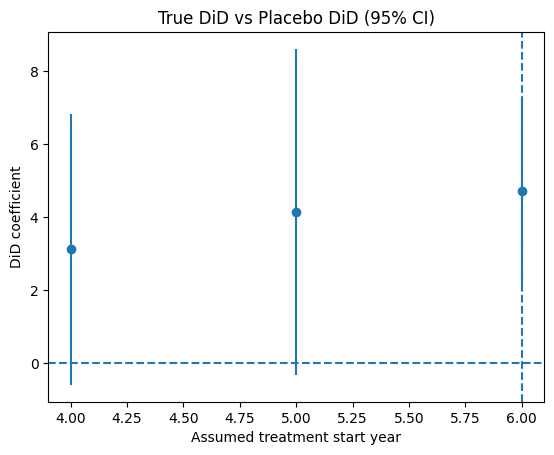

In [44]:
plt.figure()
plt.errorbar(
    compare_df["placebo_start"],
    compare_df["coef_did"],
    yerr=1.96*compare_df["se"],
    fmt="o"
)
plt.axhline(0, linestyle="--")
plt.axvline(post_start, linestyle="--")
plt.title("True DiD vs Placebo DiD (95% CI)")
plt.xlabel("Assumed treatment start year")
plt.ylabel("DiD coefficient")
plt.show()

### Comments

placeholder

## Two-way Fixed Effects

In [22]:
twfe_all = smf.ols("perf ~ class_size + gender + income + C(school_id) + C(year)", data=df).fit(
    cov_type="cluster", cov_kwds={"groups": df["school_id"]}
)
print(twfe_all.summary().tables[1])

results.append(fmt_result("TWFE: School+Year FE (all schools)", twfe_all.params["class_size"], twfe_all.bse["class_size"], int(twfe_all.nobs),
                          extra={"cluster":"school"}))

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               29.0665      0.877     33.133      0.000      27.347      30.786
C(school_id)[T.2.0]     -1.5201      0.041    -36.758      0.000      -1.601      -1.439
C(school_id)[T.3.0]     10.7135      0.807     13.271      0.000       9.131      12.296
C(school_id)[T.4.0]      7.9507      0.870      9.142      0.000       6.246       9.655
C(school_id)[T.5.0]      9.6193      0.844     11.398      0.000       7.965      11.273
C(school_id)[T.6.0]     17.4209      0.822     21.204      0.000      15.811      19.031
C(school_id)[T.7.0]     22.6036      0.768     29.423      0.000      21.098      24.109
C(school_id)[T.8.0]      4.6919      0.943      4.974      0.000       2.843       6.541
C(school_id)[T.9.0]      8.8711      0.847     10.477      0.000       7.212      10.531
C(school_id)[T.10.0] 

/home/venatio/documents/university/impact-eval-2026/.venv/lib/python3.14/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 8
  warnings.warn('covariance of constraints does not have full '


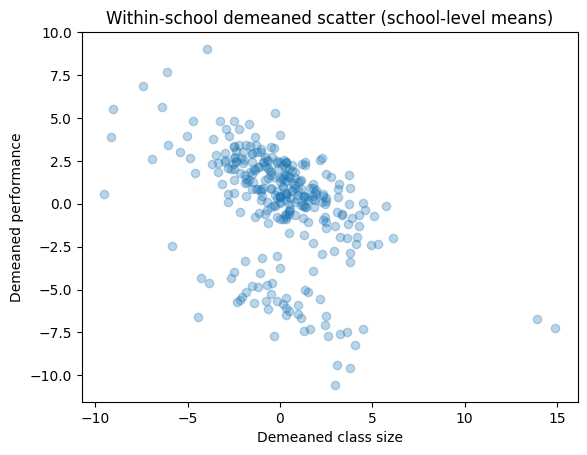

In [23]:
# within-school mean relationship (binned)
tmp = df.groupby(["school_id","year"], as_index=False).agg(perf=("perf","mean"), class_size=("class_size","mean"))
tmp["cs_dm"] = tmp["class_size"] - tmp.groupby("school_id")["class_size"].transform("mean")
tmp["pf_dm"] = tmp["perf"] - tmp.groupby("school_id")["perf"].transform("mean")

plt.figure()
plt.scatter(tmp["cs_dm"], tmp["pf_dm"], alpha=0.3)
plt.title("Within-school demeaned scatter (school-level means)")
plt.xlabel("Demeaned class size")
plt.ylabel("Demeaned performance")
plt.show()

### Comments

placeholder

## Instrumental Variables

In [24]:
MAXSIZE = 40 # this seemed best empirically (Trym)
df_ivm = df_nopilot.dropna(subset=["perf","class_size","enrollments","gender","income"]).copy()

df_ivm["pred_classes"] = np.ceil(df_ivm["enrollments"] / MAXSIZE)
df_ivm["pred_class_size"] = df_ivm["enrollments"] / df_ivm["pred_classes"]

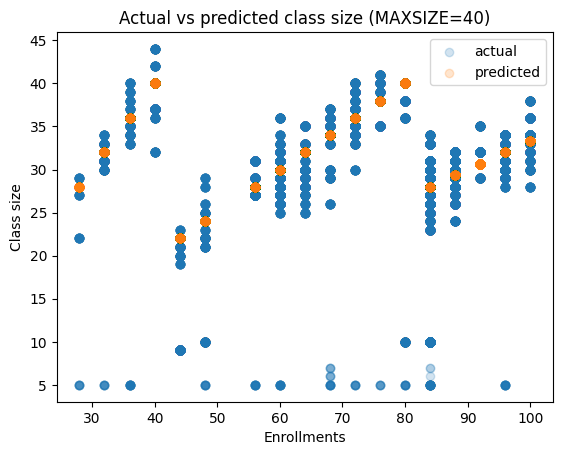

In [25]:
# 1st stage visual: enrollments -> (actual class size) and predicted class size
plt.figure()
plt.scatter(df_ivm["enrollments"], df_ivm["class_size"], alpha=0.2, label="actual")
plt.scatter(df_ivm["enrollments"], df_ivm["pred_class_size"], alpha=0.2, label="predicted")
plt.title(f"Actual vs predicted class size (MAXSIZE={MAXSIZE})")
plt.xlabel("Enrollments")
plt.ylabel("Class size")
plt.legend()
plt.show()

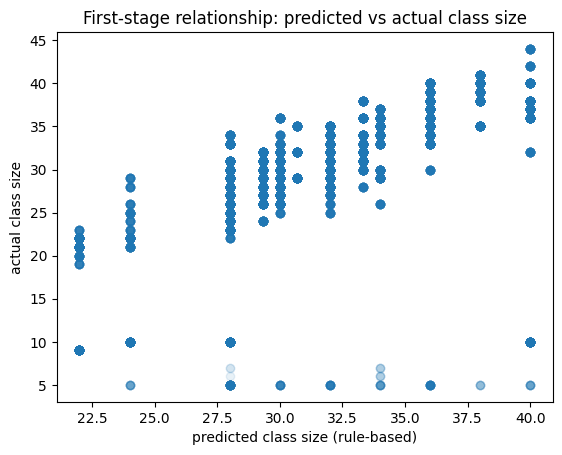

                 pred_class_size  class_size
pred_class_size         1.000000    0.619728
class_size              0.619728    1.000000


In [26]:
plt.figure()
plt.scatter(df_ivm["pred_class_size"], df_ivm["class_size"], alpha=0.1)
plt.xlabel("predicted class size (rule-based)")
plt.ylabel("actual class size")
plt.title("First-stage relationship: predicted vs actual class size")
plt.show()

print(df_ivm[["pred_class_size","class_size"]].corr())

In [27]:
iv_maim = IV2SLS.from_formula(
    "perf ~ 1 + gender + income + [class_size ~ pred_class_size]",
    data=df_ivm
).fit(cov_type="robust")

In [28]:
print(iv_maim.first_stage)

    First Stage Estimation Results    
                            class_size
--------------------------------------
R-squared                       0.3929
Partial R-squared               0.3823
Shea's R-squared                0.3823
Partial F-statistic             5848.9
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                      -0.3369
                             (-0.7846)
gender                          0.0904
                              (1.2725)
income                         -0.0251
                             (-9.5005)
pred_class_size                 1.0158
                              (76.478)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


In [29]:
print(iv_maim.summary)
results.append(fmt_result(f"IV: Maimonides predicted (MAX={MAXSIZE})", float(iv_maim.params["class_size"]), float(iv_maim.std_errors["class_size"]), int(iv_maim.nobs)))

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   perf   R-squared:                      0.7888
Estimator:                    IV-2SLS   Adj. R-squared:                 0.7888
No. Observations:               18585   F-statistic:                 3.836e+04
Date:                Tue, Feb 17 2026   P-value (F-stat)                0.0000
Time:                        19:24:36   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      46.269     0.5526     83.725     0.0000      45.186      47.353
gender         0.1086     0.1265     0.8583     0.39

### Comments

placeholder

## Fuzzy RDD

In [30]:
c = 40
h_try = [6, 8, 10, 12, 15, 20, 25] # auto widens if needed

df_base = df_nopilot.dropna(subset=["perf","class_size","enrollments","gender","income","school_id"]).copy()
df_base["x"] = df_base["enrollments"] - c
df_base["Z"] = (df_base["enrollments"] >= c).astype(int)
df_base["Zx"] = df_base["Z"] * df_base["x"]

# choose a bandwidth that has both sides
df_rdd = None
h_used = None
for h in h_try:
    d = df_base[np.abs(df_base["x"]) <= h].copy()
    d["w"] = tri_weights(d["x"].values, h)
    d = d[d["w"] > 0].copy() # drop boundary points with 0 weight (optional but clean)

    vc = d["Z"].value_counts(dropna=False)
    if d["Z"].nunique() == 2:
        df_rdd = d
        h_used = h
        break

if df_rdd is None:
    raise ValueError("RDD window never contains both sides of cutoff. Try a larger bandwidth or different cutoff.")

print("Using bandwidth h =", h_used)
print("Z counts in window:\n", df_rdd["Z"].value_counts())

Using bandwidth h = 6
Z counts in window:
 Z
1    864
0    536
Name: count, dtype: int64


In [31]:
# local linear fuzzy RDD via 2SLS (weights)
# TODO: maybe I run a gridsearch for non-linear form, and different slope?
iv_rdd = IV2SLS.from_formula(
    "perf ~ 1 + gender + income + x + [class_size ~ Z]",
    data=df_rdd,
    weights=df_rdd["w"]
).fit(cov_type="robust")

In [32]:
print(iv_rdd.first_stage)

    First Stage Estimation Results    
                            class_size
--------------------------------------
R-squared                       0.7719
Partial R-squared               0.6323
Shea's R-squared                0.6323
Partial F-statistic             2182.5
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                       14.510
                              (21.414)
gender                         -0.0718
                             (-0.3040)
income                         -0.0242
                             (-4.0602)
x                              -5.4102
                             (-67.427)
Z                               25.163
                              (46.717)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


In [33]:
print(iv_rdd.summary)

results.append(fmt_result(f"Fuzzy RDD (c={c}, h={h_used})",
                          float(iv_rdd.params["class_size"]),
                          float(iv_rdd.std_errors["class_size"]),
                          int(iv_rdd.nobs)))

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   perf   R-squared:                      0.8203
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8198
No. Observations:                1400   F-statistic:                    4289.6
Date:                Tue, Feb 17 2026   P-value (F-stat)                0.0000
Time:                        19:24:36   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      42.035     1.4940     28.136     0.0000      39.107      44.963
gender        -0.3748     0.4903    -0.7644     0.44

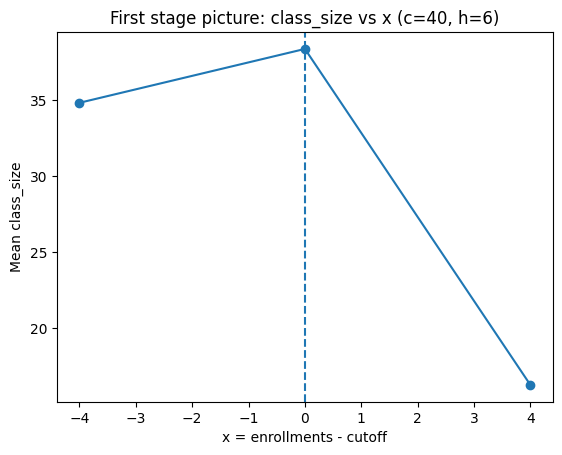

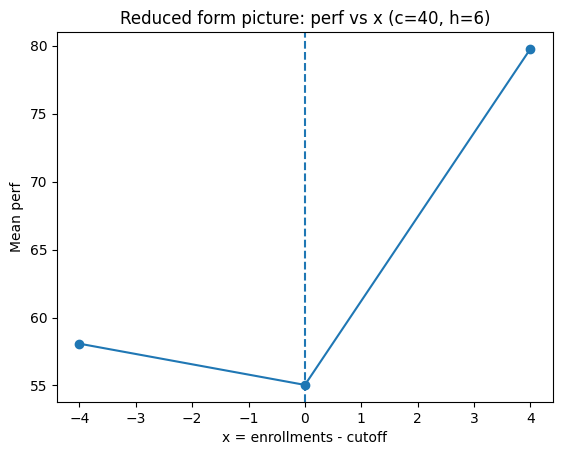

In [34]:
# binned plots around cutoff
bins = np.linspace(-h_used, h_used, 21)
df_rdd["bin"] = pd.cut(df_rdd["x"], bins=bins, include_lowest=True)

b1 = df_rdd.groupby("bin", as_index=False).agg(
    xm=("x","mean"),
    cs=("class_size","mean"),
    pf=("perf","mean"),
    n=("perf","size")
)

# 1st stage
plt.figure()
plt.plot(b1["xm"], b1["cs"], marker="o")
plt.axvline(0, linestyle="--")
plt.title(f"First stage picture: class_size vs x (c={c}, h={h_used})")
plt.xlabel("x = enrollments - cutoff")
plt.ylabel("Mean class_size")
plt.show()

# reduced form
plt.figure()
plt.plot(b1["xm"], b1["pf"], marker="o")
plt.axvline(0, linestyle="--")
plt.title(f"Reduced form picture: perf vs x (c={c}, h={h_used})")
plt.xlabel("x = enrollments - cutoff")
plt.ylabel("Mean perf")
plt.show()

### Comments

placeholder

## Synthetic Control

In [35]:
# synthetic control: school 22 (pilot) vs synthetic of non-pilot schools
treated_school = 22

# aggregate to school-year (SCM is at aggregate-unit level)
sy = df.groupby(["school_id","year"], as_index=False).agg(
    perf=("perf","mean"),
    enrollments=("enrollments","mean"),
    class_size=("class_size","mean"),
    income=("income","mean"),
    gender=("gender","mean"),
    pilot=("pilot","max")
)

# use same post_start as DiD
if "post_start" not in globals():
    pilot_mean_enr = sy[sy["pilot"]==1].groupby("year")["enrollments"].mean()
    cand = pilot_mean_enr[pilot_mean_enr <= 15].index.tolist()
    post_start = int(min(cand)) if len(cand) else int(sy["year"].min())

pre_years = sorted([y for y in sy["year"].unique() if y < post_start])
post_years = sorted([y for y in sy["year"].unique() if y >= post_start])

,donor_school,weight
9,10.0,5.774699e-01
4,5.0,1.811801e-01
0,1.0,1.694051e-01
34,39.0,7.194494e-02
6,7.0,-2.191142e-19
1,2.0,-2.403000e-19
5,6.0,-2.864614e-19
8,9.0,-3.117280e-19
14,15.0,-3.906922e-19
21,26.0,-4.306925e-19


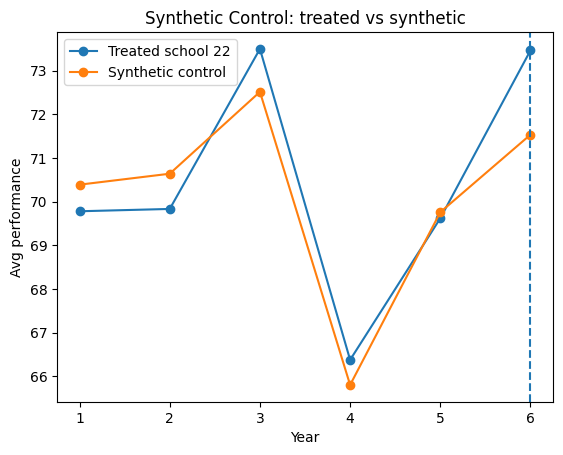

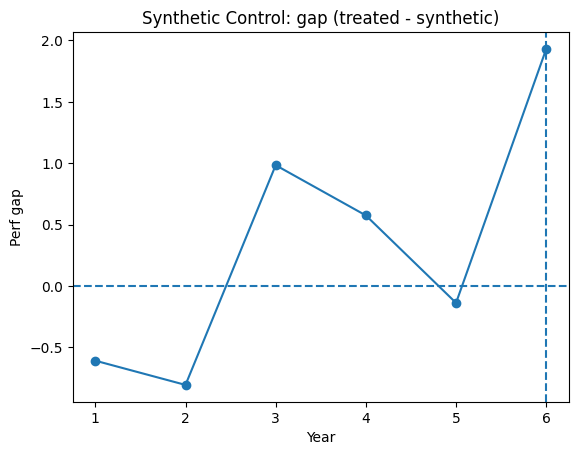

In [36]:

if treated_school not in sy["school_id"].unique() or len(pre_years) < 2:
    print("SCM not feasible (missing treated school or too few pre-years).")
    results.append(fmt_result(f"SCM ATT (school {treated_school})", np.nan, np.nan, 0))
else:
    treated = sy[sy["school_id"] == treated_school].set_index("year").sort_index()
    donors = sy[(sy["school_id"] != treated_school) & (sy["pilot"]==0)].copy()

    # donor matrix: rows=years, cols=donor schools
    Y0 = donors.pivot(index="year", columns="school_id", values="perf").reindex(pre_years)
    # keep donors with full pre-period
    Y0 = Y0.dropna(axis=1)
    donor_ids = Y0.columns.tolist()

    Y1 = treated.reindex(pre_years)["perf"].values

    # Solve min ||Y1 - Y0 w||^2 subject to w>=0, sum w=1
    J = Y0.shape[1]
    w = cp.Variable(J)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(Y1 - Y0.values @ w)),
                      [w >= 0, cp.sum(w) == 1])
    prob.solve(solver=cp.OSQP)

    w_hat = np.array(w.value).reshape(-1)
    w_df = pd.DataFrame({"donor_school": donor_ids, "weight": w_hat})
    w_df = w_df.sort_values("weight", ascending=False)
    display(w_df.head(15))

    # Build synthetic series for all years
    Y0_full = donors.pivot(index="year", columns="school_id", values="perf")[donor_ids].sort_index()
    syn = Y0_full.values @ w_hat
    years = Y0_full.index.values
    tr = treated.reindex(years)["perf"].values

    gap = tr - syn
    att = np.nanmean(gap[years >= post_start])

    # Plot treated vs synthetic
    plt.figure()
    plt.plot(years, tr, marker="o", label=f"Treated school {treated_school}")
    plt.plot(years, syn, marker="o", label="Synthetic control")
    plt.axvline(post_start, linestyle="--")
    plt.title("Synthetic Control: treated vs synthetic")
    plt.xlabel("Year")
    plt.ylabel("Avg performance")
    plt.legend()
    plt.show()

    # Plot gap
    plt.figure()
    plt.plot(years, gap, marker="o")
    plt.axvline(post_start, linestyle="--")
    plt.axhline(0, linestyle="--")
    plt.title("Synthetic Control: gap (treated - synthetic)")
    plt.xlabel("Year")
    plt.ylabel("Perf gap")
    plt.show()

    results.append(fmt_result(f"SCM ATT (school {treated_school})", float(att), np.nan, int(np.sum(years >= post_start)),
                              extra={"post_start": post_start}))

### Comments

placeholder

## Findings

In [37]:
res_df = pd.DataFrame(results)

# nicer formatting
res_df["coef"] = pd.to_numeric(res_df["coef"], errors="coerce")
res_df["SE"]   = pd.to_numeric(res_df["SE"], errors="coerce")
res_df["N"]    = pd.to_numeric(res_df["N"], errors="coerce")

res_df["t"] = res_df["coef"] / res_df["SE"]
res_df = res_df.sort_values("method").reset_index(drop=True)

display(res_df)

,method,coef,SE,N,treatment,cluster,post_start,t
0,DiD (post>= 6),4.719914,1.303894,19459,NaN,school,NaN,3.619860
1,"Fuzzy RDD (c=40, h=6)",-0.512816,0.037720,1400,NaN,NaN,NaN,-13.595190
2,IV: Maimonides predicted (MAX=40),-0.711926,0.017340,18585,NaN,NaN,NaN,-41.056310
3,"Matching (CEM bins, thresh=30)",4.984584,0.137741,18585,1[class_size<=30],NaN,NaN,36.188023
4,OLS (HC1): perf~class_size,-0.718638,0.026887,18585,NaN,NaN,NaN,-26.728506
5,SCM ATT (school 22),1.930984,NaN,1,NaN,NaN,6.0,NaN
6,Student FE + Year FE (cluster school),-0.484219,0.022605,18585,NaN,school,NaN,-21.421124
7,TWFE: School+Year FE (all schools),-0.452708,0.023036,19459,NaN,school,NaN,-19.652226
8,Twin FE + Year FE (cluster twin),-0.543400,0.039871,1636,NaN,twin,NaN,-13.629100


In [38]:
# export to CSV
#res_df.to_csv("method_comparison_table.csv", index=False)
#print("Saved: method_comparison_table.csv")

### Comments

- OLS is most vulnerable to omitted variable bias (assignment not random).
- Student FE / TWFE reduce bias from time-invariant confounding (student or school), but still require no time-varying confounding correlated with class size changes.
- Twin FE further controls for family-level confounding but uses a small/selected sample.
- IV / Fuzzy RDD estimate local causal effects driven by enrollment-rule variation; they can be larger in magnitude and are sensitive to first-stage strength and discrete running variable support.
- Matching / DiD / SCM are estimating discrete interventions (small vs large; pilot policy) rather than a marginal slope.